# Simple grokking demo with superposition

In [43]:
# Import stuff
import numpy as np
import torch as t
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import einops

## Generate Dataset

In [44]:
# Setup
p = 97
train_frac  = 0.3
device = t.accelerator.current_accelerator().type if t.accelerator.is_available() else "cpu"
device = "cpu"  # for the experiment we use cpu since mps cannot deal with float 64 apparently
print(f"Using {device} device")

Using cpu device


In [45]:
a_vec = einops.repeat(t.arange(p),"i -> (i j)",j=p)
b_vec = einops.repeat(t.arange(p),"j -> (i j)",i=p)
eq_vec = einops.repeat(t.tensor(p)," -> i",i= p**2)
# The dataset consists of pairs (x,y) with x = (a,b,eq) and y = a+b mod p
# we randomly permute the dataset and split it into train and test dataset
dataset = t.stack([a_vec,b_vec,eq_vec],dim=1).to(device=device)
labels = (dataset[:,0] + dataset[:,1]) % p
indices = t.randperm(p**2)
train_indices = indices[:int(train_frac*p**2)]
test_indices = indices[int(train_frac*p**2):]

train_dataset = dataset[train_indices]
train_labels = labels[train_indices]

test_dataset = dataset[test_indices]
test_labels = labels[test_indices]
print(train_dataset)
print(train_labels)

tensor([[82,  0, 97],
        [76, 54, 97],
        [96, 39, 97],
        ...,
        [34, 20, 97],
        [40,  9, 97],
        [ 7, 70, 97]])
tensor([82, 33, 38,  ..., 54, 49, 77])


## Create a simple one layer transformer model

This is sort of the easiest possible transformer model. It takes as input the one hot encoded token sequence (a,b,=), where = is set to p for convenience. The architecture is:

0. Token: the tokens $t_0,t_1,t_2$ are one hot encoded d_vocab dimensional vectors and the input sequence is $$t = (t_0,t_1,t_2)^T$$
1. Embedding: The tokens are embedded in the d_model dimensional space by a learnable matrix W_E $$x_0 = Embed(t) = t @W_E$$
2. Positional Embedding: The positional Embedding is implemented by adding a d_model dimensional vector to each embedded vector, depending on the token position. It is also learned. $$x_1 = x_0 + W_{pos}$$
3. Attention layer: A simple attention layer with num_heads = 4 attention heads
$$x_2 = x_1 + Attention(x_1)$$
4. MLP layer: A simple mlp with one hidden layer with ReLU activation function and no bias:
$$x_3 = x_2 + MLP(x_2)$$
5. Unembedding: a learned unembedding matrix W_U that maps back to the vocab.
$$x_4 = x_3 @ W_U$$

In [46]:
#Config for the transformer architecture
d_vocab = p+1   #The input consists of the numbers from 0 to p-1 and p for the equal sign
d_model = 128   #dimension of the model
n_ctx = 3       #context length (a,b,=) where = is encoded as 97
num_heads = 4
d_heads = d_model//num_heads
d_mlp = 4 * d_model
act_type = "ReLU"

In [47]:
from models.one_layer_transformer import Transformer

In [48]:
model = Transformer(d_model,d_mlp,d_heads,d_vocab,num_heads,n_ctx,act_type).to(device=device)


## Training

In [49]:
from torch.utils.data import DataLoader, TensorDataset

import tqdm.auto as tqdm

In [52]:
#training parameters
n_epoch = 10000
lr = 1e-3
wd = 1.
DATA_SEED = 346
betas = (0.9,0.98)

In [53]:
# Define optimizer
optimizer = t.optim.AdamW(model.parameters(),lr=lr, betas=betas,weight_decay=wd)

In [54]:
#Define cross entropy loss
def loss_fn(logits,labels):
    if len(logits.shape) == 3:
        logits = logits[:,-1]
    logits = logits.to(t.float64)   #change to 64 to prevent slingshots
    log_probs = logits.log_softmax(dim=-1)
    correct_log_probs = log_probs.gather(dim=-1,index = labels[:,None])[:,0]
    return -correct_log_probs.mean()

In [ ]:
train_losses = []
test_losses = []
for epoch in tqdm.tqdm(range(n_epoch)):
    train_logits = model(train_dataset)
    train_loss = loss_fn(train_logits,train_labels)
    train_loss.backward()
    train_losses.append(train_loss.item())
    optimizer.step()
    optimizer.zero_grad()
    with t.inference_mode():
        test_logits = model(test_dataset)
        test_loss = loss_fn(test_logits,test_labels)
        test_losses.append(test_loss.item())

    if ((epoch+1)%100)==0:
        print(f"Epoch {epoch} Train Loss {train_loss.item()} Test loss {test_loss.item()}")

  1%|          | 102/10000 [00:10<15:12, 10.85it/s]

Epoch 99 Train Loss 1.307873353702269 Test loss 9.362309605566034


  2%|▏         | 202/10000 [00:19<13:56, 11.71it/s]

Epoch 199 Train Loss 0.014695713751367027 Test loss 16.359720752068018


  3%|▎         | 302/10000 [00:27<13:47, 11.71it/s]

Epoch 299 Train Loss 0.004944934082363296 Test loss 16.855289523513424


  4%|▍         | 400/10000 [00:36<13:54, 11.50it/s]

Epoch 399 Train Loss 0.0015991300939184076 Test loss 17.640224006993233


  5%|▌         | 502/10000 [00:45<13:44, 11.52it/s]

Epoch 499 Train Loss 0.0005284346995685711 Test loss 18.50364196521268


  6%|▌         | 602/10000 [00:54<14:18, 10.95it/s]

Epoch 599 Train Loss 0.0001773083229219913 Test loss 19.36819982925809


  7%|▋         | 702/10000 [01:03<15:05, 10.26it/s]

Epoch 699 Train Loss 6.036506716554029e-05 Test loss 20.205300869092927


  8%|▊         | 802/10000 [01:12<13:17, 11.54it/s]

Epoch 799 Train Loss 2.094329557771013e-05 Test loss 21.009176487055647


  9%|▉         | 902/10000 [01:21<14:10, 10.69it/s]

Epoch 899 Train Loss 7.468339611653594e-06 Test loss 21.748858405225025


 10%|█         | 1001/10000 [01:31<12:49, 11.69it/s]

Epoch 999 Train Loss 2.8232155006809347e-06 Test loss 22.404367866864355


 11%|█         | 1101/10000 [01:40<14:42, 10.09it/s]

Epoch 1099 Train Loss 1.1915775858465665e-06 Test loss 22.899865025889948


 12%|█▏        | 1201/10000 [01:49<12:52, 11.39it/s]

Epoch 1199 Train Loss 6.027030455452532e-07 Test loss 23.184641128144364


 13%|█▎        | 1301/10000 [01:59<13:44, 10.55it/s]

Epoch 1299 Train Loss 3.8426530237243445e-07 Test loss 23.234024476126795


 14%|█▍        | 1401/10000 [02:08<12:39, 11.33it/s]

Epoch 1399 Train Loss 3.056574150615686e-07 Test loss 23.062085236797135


 15%|█▌        | 1501/10000 [02:17<13:15, 10.68it/s]

Epoch 1499 Train Loss 2.819104301812873e-07 Test loss 22.727510338538085


 16%|█▌        | 1601/10000 [02:26<11:46, 11.88it/s]

Epoch 1599 Train Loss 2.7592657722028683e-07 Test loss 22.320461931313687


 17%|█▋        | 1701/10000 [02:35<11:52, 11.65it/s]

Epoch 1699 Train Loss 2.741429386497437e-07 Test loss 21.89762610123572


 18%|█▊        | 1801/10000 [02:44<12:22, 11.05it/s]

Epoch 1799 Train Loss 2.727027633340892e-07 Test loss 21.475126629256835


 19%|█▉        | 1901/10000 [02:53<12:53, 10.47it/s]

Epoch 1899 Train Loss 2.711676889378205e-07 Test loss 21.043669396139443


 20%|█▉        | 1980/10000 [03:00<12:10, 10.98it/s]

## Plot results

In [32]:
import matplotlib.pyplot as plt

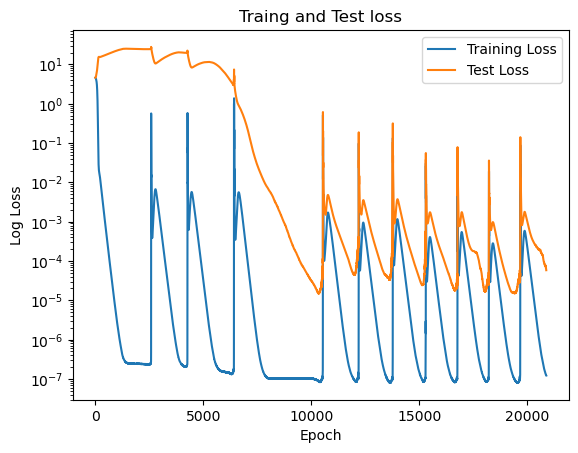

In [33]:
plt.plot(train_losses,label="Training Loss")
plt.plot(test_losses,label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Log Loss")
plt.yscale("log")
plt.title("Traing and Test loss")
plt.legend()
plt.show()

## Training with Orthograd instead
In the paper https://arxiv.org/abs/2501.04697, the authors showed basically that the delay in generalization is due to the network following a "naive loss minimization" strategy by scaling the logits, which in return leads to an absorption error in the softmax which stops the training. The logits are scaled by simply scaling all the weights of the network (which works since it is approx. homogeneous). As fix, they suggest projecting the gradient to the subspace orthogonal to the direction of the weights.

The following code which does the orthogonal projection of the gradient is also from this paper.

In [34]:
class OrthoGrad(t.optim.Optimizer):
    def __init__(self, params, base_optimizer_cls=t.optim.SGD):
        """
        A wrapper optimizer that projects gradients to be orthogonal
        to the current parameters before performing an update.
        Args:
            params (iterable): Parameter groups to optimize
            base_optimizer_cls (Optimizer class): The base optimizer class
                (e.g., torch.optim.SGD, torch.optim.AdamW).
        """
        # Minimal defaults for OrthoGrad itself (nothing special needed).
        defaults = {}
        super().__init__(params, defaults)
        # Create the wrapped/base optimizer using *our* param_groups.
        self.base_optimizer = base_optimizer_cls(self.param_groups)

    @staticmethod
    def _orthogonalize_gradients(params):
        """
        Projects the gradient g to be orthogonal to the current weights w.
        g_orth = g - ( (w·g)/(w·w + eps) ) * w
        And then re-scales g_orth to have the same norm as g.
        """
        with t.no_grad():
            for p in params:
                if p.grad is not None:
                    w = p.view(-1)
                    g = p.grad.view(-1)

                    w_norm_sq = t.dot(w, w) + 1e-30
                    proj = t.dot(w, g) / w_norm_sq
                    g_orth = g - proj * w

                    g_norm = g.norm(2)
                    g_orth_norm = g_orth.norm(2) + 1e-30
                    g_orth_scaled = g_orth * (g_norm / g_orth_norm)

                    p.grad.copy_(g_orth_scaled.view_as(p.grad))

    def step(self, closure=None):
        for group in self.param_groups:
            self._orthogonalize_gradients(group['params'])
        return self.base_optimizer.step(closure)

def get_optimizer(model, lr,optimizer,beta2,orthogonal_gradients,weight_decay,adam_epsilon):

    param_group = dict(params=model.parameters())

    if optimizer in ("Adam", "AdamW"):
        param_group |= dict(lr=lr, betas=(0.9, beta2), eps=adam_epsilon)
    elif optimizer == "SGD":
        param_group |= dict(lr=lr, momentum=0.8 if orthogonal_gradients else 0.2)
    else:
        raise ValueError(f'Unsupported optimizer type: {optimizer}')

    param_group |= dict(weight_decay=weight_decay)
    base_optimizer_cls = getattr(optim, optimizer)

    if orthogonal_gradients:
        optimizer = OrthoGrad([param_group], base_optimizer_cls)
    else:
        optimizer = base_optimizer_cls([param_group])

    return optimizer

In [35]:
lr = 1e-3
weight_decay = 0.
optimizer = "AdamW"
beta2 = 0.98
orthogoal_gradients = True
adam_epsilon = 1e-8

model_ortho = Transformer(d_model,d_mlp,d_heads,d_vocab,num_heads,n_ctx,act_type).to(device=device)
optimizer_ortho = get_optimizer(model_ortho, lr,optimizer,beta2,orthogoal_gradients,weight_decay,adam_epsilon)

In [ ]:
train_losses_ortho = []
test_losses_ortho = []
for epoch in tqdm.tqdm(range(n_epoch)):
    train_logits = model_ortho(train_dataset)
    train_loss = loss_fn(train_logits,train_labels)
    train_loss.backward()
    train_losses_ortho.append(train_loss.item())
    optimizer_ortho.step()
    optimizer_ortho.zero_grad()
    with t.inference_mode():
        test_logits = model_ortho(test_dataset)
        test_loss = loss_fn(test_logits,test_labels)
        test_losses_ortho.append(test_loss.item())

    if ((epoch+1)%100)==0:
        print(f"Epoch {epoch} Train Loss {train_loss.item()} Test loss {test_loss.item()}")

  0%|          | 101/30000 [00:07<36:42, 13.58it/s]

Epoch 99 Train Loss 2.3963918685913086 Test loss 7.034178256988525


  1%|          | 201/30000 [00:14<34:00, 14.61it/s]

Epoch 199 Train Loss 0.269834965467453 Test loss 7.04351806640625


  1%|          | 301/30000 [00:21<34:04, 14.53it/s]

Epoch 299 Train Loss 0.01707458682358265 Test loss 5.042802810668945


  1%|▏         | 403/30000 [00:28<33:42, 14.64it/s]

Epoch 399 Train Loss 0.0022286036983132362 Test loss 3.059937000274658


  2%|▏         | 501/30000 [00:35<34:44, 14.15it/s]

Epoch 499 Train Loss 0.0003900829469785094 Test loss 1.6283847093582153


  2%|▏         | 601/30000 [00:42<35:12, 13.92it/s]

Epoch 599 Train Loss 8.58381754369475e-05 Test loss 0.835365355014801


  2%|▏         | 701/30000 [00:49<34:15, 14.25it/s]

Epoch 699 Train Loss 2.1707390260417014e-05 Test loss 0.42847487330436707


  3%|▎         | 801/30000 [00:56<33:54, 14.35it/s]

Epoch 799 Train Loss 5.898295057704672e-06 Test loss 0.21513238549232483


  3%|▎         | 901/30000 [01:03<34:06, 14.22it/s]

Epoch 899 Train Loss 1.6643651861159015e-06 Test loss 0.10404935479164124


  3%|▎         | 1003/30000 [01:10<32:22, 14.93it/s]

Epoch 999 Train Loss 4.789491185874795e-07 Test loss 0.04731731861829758


  4%|▎         | 1101/30000 [01:16<32:48, 14.68it/s]

Epoch 1099 Train Loss 1.413867636301802e-07 Test loss 0.021486978977918625


  4%|▍         | 1203/30000 [01:23<32:14, 14.89it/s]

Epoch 1199 Train Loss 5.749249254449751e-08 Test loss 0.01150660403072834


  4%|▍         | 1301/30000 [01:30<33:03, 14.47it/s]

Epoch 1299 Train Loss 3.9074620872270316e-08 Test loss 0.007260574027895927


  5%|▍         | 1401/30000 [01:37<33:45, 14.12it/s]

Epoch 1399 Train Loss 3.455463826185223e-08 Test loss 0.00450638635084033


  5%|▌         | 1501/30000 [01:44<32:06, 14.79it/s]

Epoch 1499 Train Loss 3.307613738456894e-08 Test loss 0.0027594035491347313


  5%|▌         | 1601/30000 [01:50<32:41, 14.48it/s]

Epoch 1599 Train Loss 3.265370907001852e-08 Test loss 0.0019327946938574314


  6%|▌         | 1701/30000 [01:57<32:14, 14.63it/s]

Epoch 1699 Train Loss 3.2780437919655014e-08 Test loss 0.0014515232760459185


  6%|▌         | 1801/30000 [02:04<31:59, 14.69it/s]

Epoch 1799 Train Loss 3.375202339839234e-08 Test loss 0.0011982962023466825


  6%|▋         | 1901/30000 [02:11<31:57, 14.65it/s]

Epoch 1899 Train Loss 3.3625294548755846e-08 Test loss 0.000860044383443892


  7%|▋         | 2001/30000 [02:17<32:47, 14.23it/s]

Epoch 1999 Train Loss 3.569519435586699e-08 Test loss 0.0006343271816149354


  7%|▋         | 2103/30000 [02:24<30:20, 15.32it/s]

Epoch 2099 Train Loss 4.017293520064413e-08 Test loss 0.0004014619335066527


  7%|▋         | 2203/30000 [02:31<31:09, 14.87it/s]

Epoch 2199 Train Loss 4.4692917811062216e-08 Test loss 0.00020260660676285625


  8%|▊         | 2303/30000 [02:38<30:06, 15.34it/s]

Epoch 2299 Train Loss 5.7408005460501954e-08 Test loss 0.00011546686437213793


  8%|▊         | 2401/30000 [02:44<30:54, 14.88it/s]

Epoch 2399 Train Loss 6.885581882443148e-08 Test loss 0.0002091473143082112


  8%|▊         | 2503/30000 [02:51<27:07, 16.90it/s]

Epoch 2499 Train Loss 0.00026682071620598435 Test loss 0.028437696397304535


  9%|▊         | 2603/30000 [02:57<28:14, 16.16it/s]

Epoch 2599 Train Loss 1.4629957149736583e-05 Test loss 0.010920505039393902


  9%|▉         | 2703/30000 [03:03<29:21, 15.50it/s]

Epoch 2699 Train Loss 5.92312244407367e-06 Test loss 0.007267152890563011


  9%|▉         | 2803/30000 [03:10<30:12, 15.01it/s]

Epoch 2799 Train Loss 2.5630836262280354e-06 Test loss 0.004658734891563654


 10%|▉         | 2901/30000 [03:17<30:25, 14.85it/s]

Epoch 2899 Train Loss 1.1178227623531711e-06 Test loss 0.0027282047085464


 10%|█         | 3001/30000 [03:23<30:52, 14.58it/s]

Epoch 2999 Train Loss 4.908183086627105e-07 Test loss 0.0014025922864675522


 10%|█         | 3101/30000 [03:30<31:08, 14.40it/s]

Epoch 3099 Train Loss 2.17043492511948e-07 Test loss 0.0006600564229302108


 11%|█         | 3201/30000 [03:37<30:16, 14.75it/s]

Epoch 3199 Train Loss 9.804558942505537e-08 Test loss 0.00034132658038288355


 11%|█         | 3301/30000 [03:44<30:52, 14.41it/s]

Epoch 3299 Train Loss 4.3341142230701735e-08 Test loss 0.00018033743253909051


 11%|█▏        | 3403/30000 [03:51<29:47, 14.88it/s]

Epoch 3399 Train Loss 1.8671331147857018e-08 Test loss 8.389919821638614e-05


 12%|█▏        | 3503/30000 [03:58<29:47, 14.83it/s]

Epoch 3499 Train Loss 8.279594787552469e-09 Test loss 4.828500095754862e-05


 12%|█▏        | 3603/30000 [04:05<29:43, 14.80it/s]

Epoch 3599 Train Loss 1.0391737248482968e-08 Test loss 0.0002391720627201721


 12%|█▏        | 3701/30000 [04:11<30:15, 14.48it/s]

Epoch 3699 Train Loss 3.772284884462351e-08 Test loss 1.2751754184137098e-05


 13%|█▎        | 3803/30000 [04:18<24:11, 18.05it/s]

Epoch 3799 Train Loss 0.04524323344230652 Test loss 0.10371508449316025


 13%|█▎        | 3903/30000 [04:24<26:32, 16.39it/s]

Epoch 3899 Train Loss 2.8015287171001546e-05 Test loss 0.03143616393208504


 13%|█▎        | 4003/30000 [04:30<27:08, 15.96it/s]

Epoch 3999 Train Loss 1.0785409358504694e-05 Test loss 0.023514991626143456


 14%|█▎        | 4103/30000 [04:37<27:53, 15.48it/s]

Epoch 4099 Train Loss 4.7210996854119e-06 Test loss 0.017363667488098145


 14%|█▍        | 4203/30000 [04:43<27:24, 15.69it/s]

Epoch 4199 Train Loss 2.123904323525494e-06 Test loss 0.01238945685327053


 14%|█▍        | 4301/30000 [04:50<28:18, 15.13it/s]

Epoch 4299 Train Loss 9.55106088440516e-07 Test loss 0.008349675685167313


 15%|█▍        | 4401/30000 [04:57<29:42, 14.36it/s]

Epoch 4399 Train Loss 4.2859500126724015e-07 Test loss 0.005079073365777731


 15%|█▌        | 4501/30000 [05:03<29:19, 14.49it/s]

Epoch 4499 Train Loss 1.9250045113494707e-07 Test loss 0.0026471861638128757


 15%|█▌        | 4603/30000 [05:10<28:22, 14.92it/s]

Epoch 4599 Train Loss 8.765385928199976e-08 Test loss 0.0012361692497506738


 16%|█▌        | 4701/30000 [05:17<28:53, 14.59it/s]

Epoch 4699 Train Loss 3.6497805666613203e-08 Test loss 0.0006204048986546695


 16%|█▌        | 4801/30000 [05:24<28:22, 14.80it/s]

Epoch 4799 Train Loss 1.2377149083420136e-08 Test loss 0.00025214077322743833


 16%|█▋        | 4901/30000 [05:31<28:20, 14.76it/s]

Epoch 4899 Train Loss 8.026137976457903e-09 Test loss 0.00017506339645478874


 17%|█▋        | 5001/30000 [05:38<28:33, 14.59it/s]

Epoch 4999 Train Loss 1.0560707863760399e-08 Test loss 0.00014069056487642229


 17%|█▋        | 5103/30000 [05:44<24:05, 17.22it/s]

Epoch 5099 Train Loss 0.10868170112371445 Test loss 0.8452440500259399


 17%|█▋        | 5203/30000 [05:50<25:08, 16.43it/s]

Epoch 5199 Train Loss 1.7736545487423427e-05 Test loss 0.03569277748465538


 18%|█▊        | 5303/30000 [05:56<25:47, 15.96it/s]

Epoch 5299 Train Loss 6.7046566982753575e-06 Test loss 0.02944464422762394


 18%|█▊        | 5403/30000 [06:03<26:14, 15.62it/s]

Epoch 5399 Train Loss 2.9417715268209577e-06 Test loss 0.02419269271194935


 18%|█▊        | 5503/30000 [06:09<26:10, 15.60it/s]

Epoch 5499 Train Loss 1.302884925280523e-06 Test loss 0.019336862489581108


 19%|█▊        | 5603/30000 [06:15<26:09, 15.54it/s]

Epoch 5599 Train Loss 5.710367076972034e-07 Test loss 0.01491259690374136


 19%|█▉        | 5703/30000 [06:22<24:30, 16.52it/s]

Epoch 5699 Train Loss 2.499504887509829e-07 Test loss 0.010946975089609623


 19%|█▉        | 5803/30000 [06:28<24:59, 16.14it/s]

Epoch 5799 Train Loss 1.1126756049861797e-07 Test loss 0.007418155670166016


 20%|█▉        | 5903/30000 [06:35<24:47, 16.20it/s]

Epoch 5899 Train Loss 4.904392625348919e-08 Test loss 0.004584085661917925


 20%|██        | 6003/30000 [06:41<24:49, 16.11it/s]

Epoch 5999 Train Loss 1.947394601131691e-08 Test loss 0.002419466618448496


 20%|██        | 6103/30000 [06:47<24:56, 15.97it/s]

Epoch 6099 Train Loss 6.50539577762288e-09 Test loss 0.001081652706488967


 21%|██        | 6203/30000 [06:53<24:40, 16.08it/s]

Epoch 6199 Train Loss 5.322597029788767e-09 Test loss 0.00021969630324747413


 21%|██        | 6303/30000 [07:00<24:44, 15.96it/s]

Epoch 6299 Train Loss 1.1278835643224738e-08 Test loss 0.00011867612192872912


 21%|██▏       | 6402/30000 [07:05<21:18, 18.45it/s]

Epoch 6399 Train Loss 2.225799653388094e-05 Test loss 0.022433606907725334


 22%|██▏       | 6502/30000 [07:10<21:38, 18.09it/s]

Epoch 6499 Train Loss 6.431238489312818e-06 Test loss 0.017217550426721573


 22%|██▏       | 6602/30000 [07:16<22:54, 17.02it/s]

Epoch 6599 Train Loss 2.7557098292163573e-06 Test loss 0.013942857272922993


 22%|██▏       | 6702/30000 [07:22<22:44, 17.08it/s]

Epoch 6699 Train Loss 1.207623881782638e-06 Test loss 0.011075770482420921


 23%|██▎       | 6802/30000 [07:28<22:44, 17.00it/s]

Epoch 6799 Train Loss 5.241045073489659e-07 Test loss 0.008427067659795284


 23%|██▎       | 6902/30000 [07:34<22:45, 16.92it/s]

Epoch 6899 Train Loss 2.2971616431277653e-07 Test loss 0.0059997099451720715


 23%|██▎       | 7002/30000 [07:40<23:11, 16.53it/s]

Epoch 6999 Train Loss 1.0091807922663065e-07 Test loss 0.0038595690857619047


 24%|██▎       | 7102/30000 [07:46<23:46, 16.05it/s]

Epoch 7099 Train Loss 4.312992629706969e-08 Test loss 0.00210599135607481


 24%|██▍       | 7202/30000 [07:52<27:40, 13.73it/s]

Epoch 7199 Train Loss 1.795320336839268e-08 Test loss 0.0010473025031387806


 24%|██▍       | 7302/30000 [07:59<25:45, 14.69it/s]

Epoch 7299 Train Loss 6.251938966528314e-09 Test loss 0.0005882935365661979


 25%|██▍       | 7402/30000 [08:06<25:21, 14.85it/s]

Epoch 7399 Train Loss 2.914755548033554e-09 Test loss 0.0004440782649908215


 25%|██▌       | 7502/30000 [08:12<25:00, 14.99it/s]

Epoch 7499 Train Loss 3.9285832365010265e-09 Test loss 0.00018060831644106656


 25%|██▌       | 7602/30000 [08:19<25:41, 14.53it/s]

Epoch 7599 Train Loss 1.4869476316903274e-08 Test loss 3.204915628884919e-05


 26%|██▌       | 7702/30000 [08:24<21:04, 17.63it/s]

Epoch 7699 Train Loss 1.5715779227321036e-05 Test loss 0.020972970873117447


 26%|██▌       | 7802/30000 [08:30<22:31, 16.43it/s]

Epoch 7799 Train Loss 4.8737133511167485e-06 Test loss 0.01656593754887581


 26%|██▋       | 7902/30000 [08:36<22:24, 16.43it/s]

Epoch 7899 Train Loss 2.0405323084560223e-06 Test loss 0.013251567259430885


 27%|██▋       | 8002/30000 [08:43<22:55, 15.99it/s]

Epoch 7999 Train Loss 8.790232755018224e-07 Test loss 0.010389728471636772


 27%|██▋       | 8102/30000 [08:49<23:27, 15.55it/s]

Epoch 8099 Train Loss 3.787058062698634e-07 Test loss 0.00787954032421112


 27%|██▋       | 8202/30000 [08:55<23:25, 15.51it/s]

Epoch 8199 Train Loss 1.6208556985475298e-07 Test loss 0.005629663355648518


 28%|██▊       | 8302/30000 [09:02<23:41, 15.27it/s]

Epoch 8299 Train Loss 6.894027393400393e-08 Test loss 0.0035953449551016092


 28%|██▊       | 8402/30000 [09:08<24:42, 14.57it/s]

Epoch 8399 Train Loss 2.9105310161980924e-08 Test loss 0.00206896779127419


 28%|██▊       | 8502/30000 [09:15<24:32, 14.60it/s]

Epoch 8499 Train Loss 1.106762148594953e-08 Test loss 0.0011416663182899356


 29%|██▊       | 8602/30000 [09:22<23:41, 15.05it/s]

Epoch 8599 Train Loss 3.6328835495424983e-09 Test loss 0.0006122373160906136


 29%|██▉       | 8702/30000 [09:28<23:31, 15.09it/s]

Epoch 8699 Train Loss 2.3233557300272878e-09 Test loss 0.0003636908659245819


 29%|██▉       | 8802/30000 [09:35<24:08, 14.63it/s]

Epoch 8799 Train Loss 2.830269796305629e-09 Test loss 0.00017053360352292657


 30%|██▉       | 8902/30000 [09:42<24:06, 14.58it/s]

Epoch 8899 Train Loss 1.178574926541387e-08 Test loss 5.946418605162762e-05


 30%|███       | 9002/30000 [09:47<21:08, 16.55it/s]

Epoch 8999 Train Loss 2.3923350454424508e-05 Test loss 0.04314916953444481


 30%|███       | 9102/30000 [09:53<21:19, 16.33it/s]

Epoch 9099 Train Loss 7.192447810666636e-06 Test loss 0.0347115732729435


 31%|███       | 9202/30000 [10:00<21:40, 15.99it/s]

Epoch 9199 Train Loss 3.0359055926965084e-06 Test loss 0.02881760522723198


 31%|███       | 9302/30000 [10:06<21:58, 15.70it/s]

Epoch 9299 Train Loss 1.3329579360288335e-06 Test loss 0.023390401154756546


 31%|███▏      | 9402/30000 [10:12<21:49, 15.73it/s]

Epoch 9399 Train Loss 5.932980116085673e-07 Test loss 0.018335683271288872


 32%|███▏      | 9502/30000 [10:19<21:45, 15.70it/s]

Epoch 9499 Train Loss 2.649888131145417e-07 Test loss 0.013884791173040867


 32%|███▏      | 9602/30000 [10:25<21:52, 15.54it/s]

Epoch 9599 Train Loss 1.181953592777063e-07 Test loss 0.01023791916668415


 32%|███▏      | 9702/30000 [10:32<22:16, 15.19it/s]

Epoch 9699 Train Loss 5.153624371700971e-08 Test loss 0.007355516776442528


 33%|███▎      | 9802/30000 [10:38<22:33, 14.92it/s]

Epoch 9799 Train Loss 2.1839541730628298e-08 Test loss 0.005062555428594351


 33%|███▎      | 9902/30000 [10:45<22:03, 15.19it/s]

Epoch 9899 Train Loss 7.603709661907487e-09 Test loss 0.0029136845842003822


 33%|███▎      | 10002/30000 [10:52<22:16, 14.96it/s]

Epoch 9999 Train Loss 3.041483953580837e-09 Test loss 0.0010436041047796607


 33%|███▎      | 10010/30000 [10:52<21:43, 15.33it/s]


KeyboardInterrupt: 

In [41]:
print(train_losses_ortho)

[]


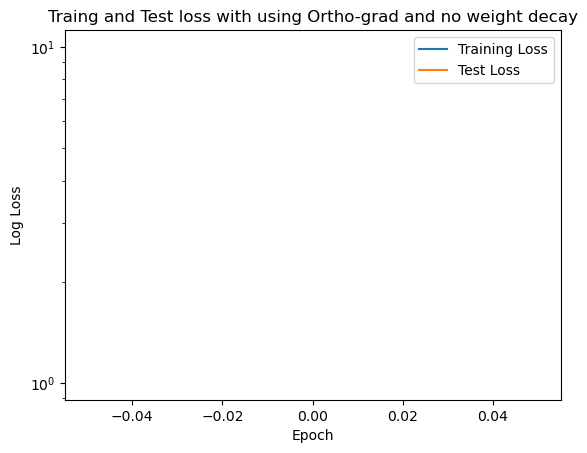

In [ ]:
plt.plot(train_losses_ortho,label="Training Loss")
plt.plot(test_losses_ortho,label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Log Loss")
plt.yscale("log")
plt.title("Traing and Test loss with using Ortho-grad and no weight decay")
plt.legend()
plt.show()